In [34]:
##First declare our imports
%matplotlib inline
from IPython.display import clear_output
from brian2 import *
import time as pyt
import numpy as np
import scipy.stats as stats

# Network simulation code
Below we define the network simulation code. This includes the CRH neurons, the GABA neurons, and the synapses. In addition we have added a number of keyword based manipulations for you to try:
To apply the manipulations you can to provide a python dict in the form of 
```
events = {<time>: <event string>}
```
where `<event string>` is a predetermined string. See ``help(run_network_simulation)`` for a list of possible manipulations.

In [35]:
#now declare our network simulation function.

#this is helpful as we call it repeatdly 
def run_network_simulation(run_time=60, hz_in=30, gaba_pr=1, network_events={}, gaba_pr_decay=40, adapt_decay=80):
    """ runs the network simulation for the specified run time. Includes the ability to change the input EPSP and the inhibition strength (GABA Pr).
    Also includes the ability to apply manipulations to the network post running
    
    Takes:
    run_time (int): the total run time of the network in seconds. Defaults to 60
    hz_in (float): the incoming EPSP freq. in hertz or spikes/s. Defaults to 30.
    gaba_pr (float): the probability of release at the GABA synapse. Controls inhibitory strength. should
                    be a float between [0,1]. Defaults to 1
    network_events (dict): manipulations to be applied to the network after starting a run. should be in the format of
                        {<time (in seconds)> : <event string>}, where the time to apply the manipulation is the key, and the event to apply is the value.
                        Possible <event strings> include:
                            double_EPSP => doubles the incoming EPSP frequency.
                            triple_EPSP => triples the incoming EPSP frequency.
                            disconnect_GABA_increase_adapt => drops the GABA Pr and increases the adaptation current. Putting the network into single spiking mode observed in vivo.
                            disconnect_GABA => drops the GABA Pr without increasing the adaptation current.
                            increase_adapt => increases the adaptation current without the loss of inhibition.
                            
    returns:
    M (brian2 spike monitor): a brian2 spike monitor containing all the spikes for the CRH neuron
    V (brian2 variable monitor): a brian2 variable monitor containing the voltage, adaptation, etc. recorded for the first two CRH neurons
    
    
    """
    start_scope() #this reinitializes brian 2
    start_time = pyt.time()
    seed(4323)
    # network parameters
    N = 1e3
    p_ei = 0.02
    p_ie = 0.04 # e->i & i->e connection probability

    # neuron parameters
    C = 21.64577686 * pF
    taum = 26.45276208*ms
    gL = C/taum #30 * nS
    DeltaT = 12.0032413*mV
    pr = 1
    EL = -67.91702674 * mV
    VT = -55.19868804 * mV
    VR = -71.40471178 * mV
    #Here we declare our cell parameters with some varaiation
    CRH_param = {'tauw': np.clip(skew_norm(92.41, 10, mag=5), 6, 999)*ms, 'a': np.random.normal(loc=0.090873665, scale=0.0001, size=500)*nS, 
           'b': np.clip(skew_norm(18, 3, mag=3), 6, 999)*pA } # low-threshold spiking(?)
    GABA_param = {'tauw': 13.5686673*ms, 'a': 0.*nS, 'b': 3*pA }
 
    # synapse parameters
    Ee = 0 * mvolt
    Ei = -80 * mvolt
    taue =18.14* msecond
    tauCRH = 350.7198441 * msecond
    taui = 11.96379858 * msecond
    wCRH = 0.005620078 * nS
    we = 5.371492379 * nS
    wi = 12.54548072 * nS
    taup = gaba_pr_decay *second
    taubr = adapt_decay * second

    #Some cells will be by default in single spiking
    per = int(1e-5 * 500)
    rand_id = np.random.randint(0, 500, per)
    pr_ar = np.full(1000, gaba_pr)
    pr_ar[rand_id] = np.clip(np.random.rand(per), 0.002, 0.6)
    b_ar = np.full(500, CRH_param['b']/pA)*pA
    CRH_param['tauw'][rand_id] #*= 2
    b_ar[rand_id] = (18.14 * (5 + ((1-pr_ar[rand_id] + rand(per))* 20)))*pA#(2 + np.random.rand(per))*20)*pA
    #taup
    taup = np.full(1000, taup/second)*second
    taubr = np.full(1000, taubr/second)*second
    taup[rand_id] = 1000000 * second
    taubr[rand_id] = 1000000 * second

    #now define our equations, in short these are simple adex models.
    eqs = Equations('''
    dv/dt = ( gL*(EL-v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v) + gi*(Ei-v) - w) * (1./C) : volt (unless refractory)
    dw/dt = ( a*(v - EL) - w ) / tauw : amp 
    dgi/dt = -gi*(1./taui) : siemens
    dy/dt = -y*(1./taue) : siemens
    dbd/dt = -bd*(1./taubr): amp
    dge/dt = (y-ge)/taue : siemens
    dpr/dt = (1./taup) * pr * (1 - (pr/1)): 1
    d_I = clip(( ge*(Ee-v) + gi*(Ei-v) - w), -5550*pA, 5550*pA) : amp 
    p_w = clip(pr, 0.01,1): 1
    br = b + bd : amp
    tauw : second
    taue : second
    taui : second
    a : siemens
    I : amp
    b: amp
    Vcut: volt
    VT : volt
    refrac : second
    taup: second
    taubr : second
    input_1 : 1
    input_2 : 1
    input_3 : 1''')


    # build network
    P = NeuronGroup( N, model=eqs, threshold='v>Vcut', reset='v=VR; w+=br', refractory='refrac')
    P.pr = 1
    P.VT = VT
    P.Vcut = (VT + 5 * DeltaT )
    P.taui = taui
    
    #apply the individual parameters to the populations
    CRH = P[:int(floor(0.5*N))]; GABA = P[int(floor(0.5*N)):] #half of the GABA
    CRH.tauw = CRH_param['tauw']; CRH.a = CRH_param['a']; CRH.b = CRH_param['b']
    GABA.tauw = GABA_param['tauw']; GABA.a = GABA_param['a']; GABA.b = GABA_param['b']
    GABA.taue = tauCRH; CRH.taue = taue
    GABA.refrac = 1*ms
    CRH.refrac = 0.5*ms
    P.pr=pr_ar
    CRH.bd=b_ar
    P.taup=taup
    P.taubr=taubr
    # connect CRH and GABA together
    EI = Synapses( CRH, GABA, on_pre='y=clip((y + wCRH), 0*nS, 30*nS)' ) #*(rand()<p_w)
    EI.connect( True, p=p_ei )
    IE = Synapses( GABA, CRH, on_pre='gi=clip((wi*int(rand()<p_w)) + gi, 0*nS, 30*nS)' ) #*(rand()<p_w)
    IE.connect( True, p=p_ie )

    # poisson input
    input = PoissonInput(CRH, 'ge', 1, hz_in*Hz, weight='we*input_1') #brian2 does not allow dynamic modulation of input freq so we have to hardcode the input here. 
    input2 = PoissonInput( CRH, 'ge', 1, (hz_in*2)*Hz, weight='we*input_2')
    input3 = PoissonInput( CRH, 'ge', 1, (hz_in*3)*Hz, weight='we*input_3')
    P.input_1 = 1
    P.input_2 = 0
    P.input_3 = 0
    
    # init
    P.v = ((randn(len(P)) * (2* mV))) + EL
    P.ge = (randn(len(P)) * 2 + 5) * nS
    P.gi = ((randn(len(P)) * 2 + 5) + 0) * nS
    # monitor
    M = SpikeMonitor( CRH ) #record the CRH Spikes
    V = StateMonitor( CRH, ['v', 'w', 'I', 'gi', 'ge', 'y', 'p_w', 
                           'pr', 'br', 'd_I'], record=[5], dt=(1/10000)*second ) #record the membrane potential
    # run simulation
    
    print("=== Net Sim Start ===")
    if len(network_events.keys())<1:
        #if the user gives no events just run as is
        run(run_time*second)
    else:
        #if there are events we can apply them
        run_time = np.diff(np.hstack([0, *list(network_events.keys()), run_time])) #this is some funky python, but I am computing out the run time between events
        events = np.hstack(['none', *list(network_events.values())]) #here we are also expanding out the listed evets
        print(events)
        print(run_time)
        for time, event in zip(run_time, events):
          if event=='none':
                pass
          if event=='double_EPSP':
            print("Increasing EPSP")
            P.input_1 = 0
            P.input_2 = 1
            P.input_3 = 0
          if event=='triple_EPSP':
            print("Increasing EPSP")
            P.input_1 = 0
            P.input_2 = 0
            P.input_3 = 1
          if event=='disconnect_GABA_increase_adapt':
            print("Removing GABA and increasing Adaptation")
            pr_ar = np.full(1000, np.random.rand(1000)*0.1)
            b_ar = np.full(500, CRH_param['b']/pA * (5+(np.random.rand(500))*20))

            print(b_ar.max()) 
            print(pr_ar.max())
            P.pr=pr_ar
            CRH.bd=b_ar*pA
          if event=='disconnect_GABA':
            print("Removing GABA ONLY")
            pr_ar = np.full(1000, np.random.rand(1000)*0.1)
            P.pr=pr_ar
          if event=='increase_adapt':
            print("increasing Adaptation")
            b_ar = np.full(500, CRH_param['b']/pA * (5+(np.random.rand(500))*20))
            CRH.bd=b_ar*pA
           
          run(time* second, report='text')
    print(f"simulation took {(pyt.time()-start_time)/60}")
    return M, V


def skew_norm(mean, scale, n=500, mag=5, skew='left'):
    if skew=='left':
        smean = mean - (mag * 0.5)
    else:
        smean = mean + (mag * 0.5)
    rand = stats.skewnorm.rvs(mag, loc=mean, scale=scale, size=n)
    return rand

## FIGURE 5 (D): Run the baseline network

First, we will run the baseline excitatory network! This features the basic inhibitory and excitatory network cycle.

![title](./single_UNIT_CIRCUT.png)

We will run the network for 60 seconds as a baseline. Below we will call the function declared earlier with the default parameters

In [36]:
spike_times, voltage = run_network_simulation()

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


=== Net Sim Start ===
simulation took 1.3136859019597371


Now we can plot our spike raster. Note the first ~1.5s include the start up of the network, the network will take a while before beginning to cycle.

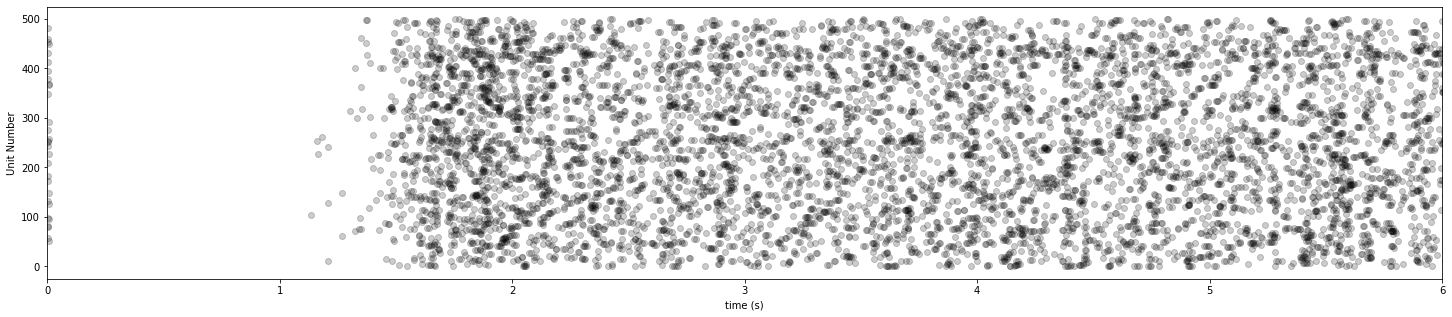

In [37]:
def spike_raster(spike_trains, xlim=(0, 6)):
    plt.figure(figsize=(25,5))
    for key, item in spike_trains.items():
        plt.scatter(item, np.full(len(item), key), c='k', alpha=0.2)
    plt.ylabel('Unit Number')
    plt.xlabel('time (s)')
    plt.xlim(xlim)
    plt.show()
spike_raster(spike_times.spike_trains())

See the network bursts in a semi-asynchronous manner. We can highlight the bursts in red below

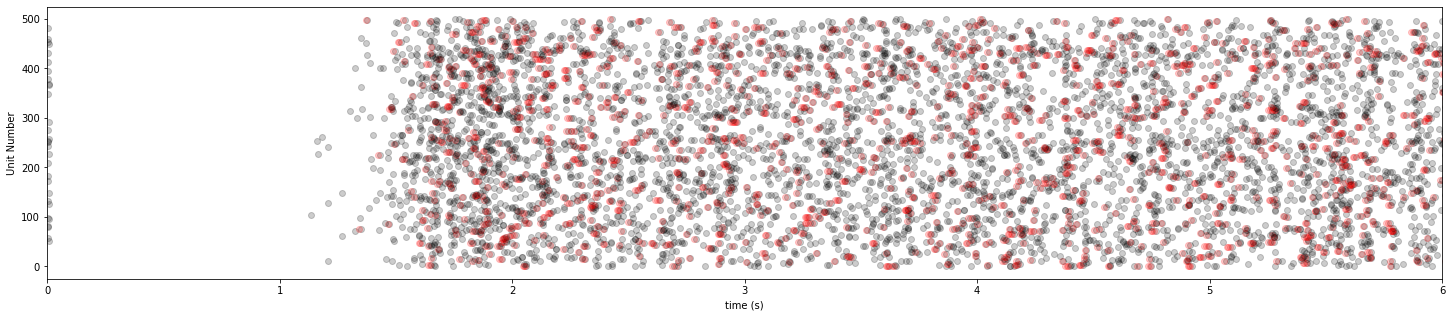

In [38]:
def spike_raster_with_bursts(spike_trains, xlim=(0, 6)):
    plt.figure(figsize=(25,5))
    for key, item in spike_trains.items():
        isi = np.append(np.diff(item/ms),99)
        bursts = item[isi<=10]
        non_burst = item[isi>=10]
        plt.scatter(non_burst, np.full(len(non_burst), key),c='k', alpha=0.2)
        plt.scatter( bursts, np.full(len( bursts), key),c='r', alpha=0.2)
    plt.ylabel('Unit Number')
    plt.xlabel('time (s)')
    plt.xlim(xlim)
    plt.show()
spike_raster_with_bursts(spike_times.spike_trains())

Now we can take a closer look at a single unit. Here we will look at the ISI over time plot. This plots each spike as its temporal moment (x-axis) and preceding ISI (y-axis). This allows us to quickly assess the firing pattern of the neuron. Here we can see the characteristic double banding of burst firing. A single band below 10^1 ms (burst), and a band above 10^2 ms (long silence). 

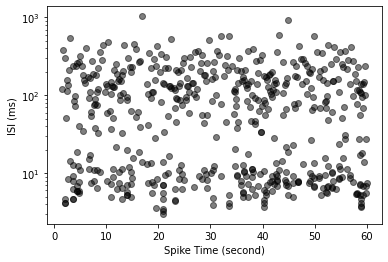

In [39]:
def isi_time_plot(spike_trains, unit_no=1):
    unit_times = spike_trains[unit_no]
    unit_isi = np.diff(unit_times/ms)
    #plot the isi over time
    plt.scatter(unit_times[:-1], unit_isi, c='k', alpha=0.5)
    #Scale the y axis to log
    plt.yscale('log')
    plt.ylabel('ISI (ms)')
    plt.xlabel('Spike Time (second)')
isi_time_plot(spike_times.spike_trains())
    

Finally, lets take a look at the overall firing rate of the network. Here we will bin time into slices, and take the average firing rate across units for this slice.

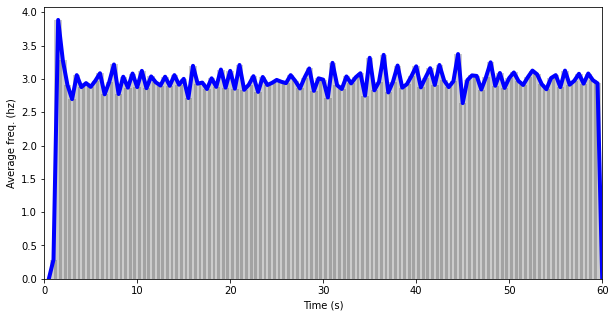

In [40]:
def binned_hz_pop(isi, time, popsize=500, binsize=500, bar_col='k', line_col='b', label=''):
    binned_isi_hz = []
    bins = np.arange(0, time, binsize)
    bins_right = np.arange(binsize, time + binsize, binsize)
    for x, x_r in zip(bins, bins_right):
        temp_isi_array = []
        for u in np.arange(popsize):
            temp_isi = isi[u] / second
            temp_isi *= 1000
            filtered_isi = temp_isi[np.logical_and(temp_isi>=x, temp_isi<x_r)]
            temp_isi_array.append((len(filtered_isi)/(binsize/1000)))
        binned_isi_hz.append(np.nanmean(temp_isi_array))
    hz = np.hstack(binned_isi_hz)
    plt.figure(3, figsize=(10,5))
    plt.bar(bins[1:]/1000, hz[1:], color=bar_col, alpha=0.2)
    plt.plot(bins[1:]/1000, hz[1:], color=line_col, lw=4, label=label)
    plt.xlim(0,60)
    #plt.ylim(0,4.5)
    plt.ylabel("Average freq. (hz)")
    plt.xlabel("Time (s)")   
    return hz, bins
hz, bin_time = binned_hz_pop(spike_times.spike_trains(), 600000)

        

save the spike times for later

In [41]:
def equal_ar_size_from_list(isi_list):
    lsize = len(max(isi_list, key=len))
    new_list = []
    for x in isi_list:
        new_list.append(np.hstack((x, np.full((lsize-len(x)), np.nan))))
    return np.vstack(new_list)

def save_spike_times(spike_times, tag='default'):
    unit_spike_times = []
    unit_br = []
    for unit in np.arange(500):
        unit_spike_times.append(spike_times.spike_trains()[unit]/second)
    np.savetxt(f"unit_spike_times_{tag}.csv",  equal_ar_size_from_list(unit_spike_times).T, delimiter=',', fmt='%.8f')

save_spike_times(spike_times)

and save the currents for use in clampex / pclamp

In [42]:
def save_net_currents(statemonitor, spike_times, split_time=30, tag='default', sample_rate=10000):
    spike_times = np.savetxt(f"low_burst_spikes_{tag}.csv", spike_times.spike_trains()[5]/second, fmt="%.18f", delimiter=',')
    idx_100 = np.int32(30/(1/sample_rate))
   
    low_phase_1 = (statemonitor[5].d_I/pA)[:idx_100]
    low_phase_2 = (statemonitor[5].d_I/pA)[idx_100:]

    low_out_scaled = np.vstack((low_phase_1, low_phase_1*1.5, low_phase_1 * 2))
    low_out_repeat = np.vstack((low_phase_1, low_phase_1, low_phase_1))
    from pyabf import abfWriter
    #(low_phase_1, filename="low_burst_phase1.atf", rate=10000.0)
    abfWriter.writeABF1(low_out_scaled, filename=f"low_burst_scaled_{tag}.abf", sampleRateHz=sample_rate)
    abfWriter.writeABF1(low_out_repeat, filename=f"low_burst_repeat_{tag}.abf", sampleRateHz=sample_rate)

    low_out_scaled = np.vstack((low_phase_2, low_phase_2*1.5, low_phase_2 * 2))
    low_out_repeat = np.vstack((low_phase_2, low_phase_2, low_phase_2))
    abfWriter.writeABF1(low_out_scaled, filename=f"low_burst_2_scaled_{tag}.abf", sampleRateHz=sample_rate)
    abfWriter.writeABF1(low_out_repeat, filename=f"low_burst_2_repeat_{tag}.abf", sampleRateHz=sample_rate)
save_net_currents(voltage, spike_times)

# Figure 5 (G): Drop the GABA Pr alone
Now we will simply drop the GABA Pr in the absence of any other manipulation.

In [43]:
spike_times, voltage = run_network_simulation(network_events={30:'disconnect_GABA'}, gaba_pr_decay=1e6)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup_1__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


=== Net Sim Start ===
['none' 'disconnect_GABA']
[30 30]
Starting simulation at t=0. s for a duration of 30. s
10.5722 s (35%) simulated in 10s, estimated 18s remaining.
20.5057 s (68%) simulated in 20s, estimated 9s remaining.
30. s (100%) simulated in 29s
Removing GABA ONLY


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup_1__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


Starting simulation at t=30. s for a duration of 30. s
9.6848 s (32%) simulated in 10s, estimated 21s remaining.
19.2796 s (64%) simulated in 20s, estimated 11s remaining.
28.8492 s (96%) simulated in 30s, estimated 1s remaining.
30. s (100%) simulated in 31s
simulation took 1.3355530778566995


Now we can generate our plots

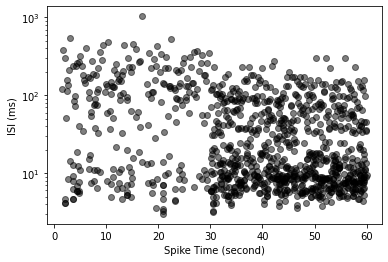

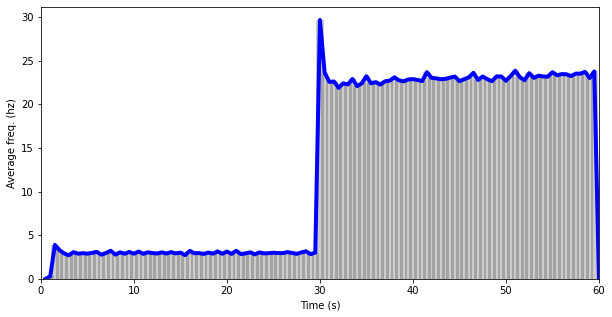

In [44]:
isi_time_plot(spike_times.spike_trains())
hz, bin_time = binned_hz_pop(spike_times.spike_trains(), 600000)

save_spike_times(spike_times)and save the data

In [45]:
save_spike_times(spike_times, tag='drop_gaba')
save_net_currents(voltage, spike_times, tag='drop_gaba')

# Figure 5 (K): Run the network dropping Pr and increasing adaptation
Now we will try running the network and dropping the Pr at the same time as increasing the adaptation.

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


=== Net Sim Start ===
['none' 'disconnect_GABA_increase_adapt']
[30 30]
Starting simulation at t=0. s for a duration of 30. s
10.4968 s (34%) simulated in 10s, estimated 19s remaining.
20.1885 s (67%) simulated in 20s, estimated 10s remaining.
30. s (100%) simulated in 29s
Removing GABA and increasing Adaptation
603.3364692799414
0.09981044699939307


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


Starting simulation at t=30. s for a duration of 30. s
9.6896 s (32%) simulated in 10s, estimated 21s remaining.
19.3597 s (64%) simulated in 20s, estimated 11s remaining.
29.1114 s (97%) simulated in 30s, estimated 1s remaining.
30. s (100%) simulated in 30s
simulation took 1.3422975579897563


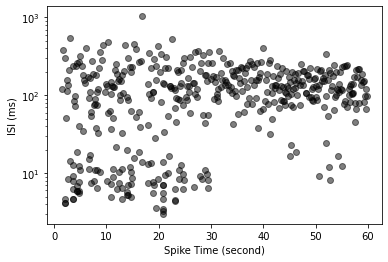

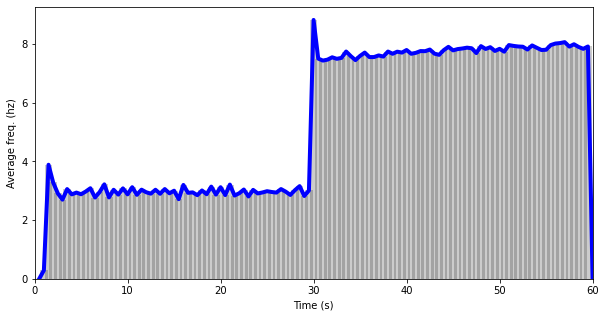

In [46]:
spike_times, voltage = run_network_simulation(network_events={30:'disconnect_GABA_increase_adapt'})
isi_time_plot(spike_times.spike_trains())
hz, bin_time = binned_hz_pop(spike_times.spike_trains(), 600000)
save_spike_times(spike_times, tag='drop_gaba')
save_net_currents(voltage, spike_times, tag='drop_gaba')

## Figure 5 (P): Remove recurrent inhibition and increase the EPSP.

Now we can try removing the recurrent inhibition. Thus meaning CRH neurons are operating independently, taking in EPSPs, integrating them, and outputting spikes.

![image.png](./single_unit_circut_cut.png)

Then we can try increasing the EPSP and see if the overall firing rate of the network changes.

We will disconnect the GABA at 200 seconds, and increase the EPSP at 400 seconds

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup_1__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


=== Net Sim Start ===
['none' 'disconnect_GABA_increase_adapt' 'double_EPSP']
[15 15 30]
Starting simulation at t=0. s for a duration of 15. s
10.3395 s (68%) simulated in 10s, estimated 5s remaining.
15. s (100%) simulated in 15s


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup_1__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


Removing GABA and increasing Adaptation
611.2149727923829
0.09999364332105744
Starting simulation at t=15. s for a duration of 15. s
9.4587 s (63%) simulated in 10s, estimated 6s remaining.
15. s (100%) simulated in 15s
Increasing EPSP


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup_1__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


Starting simulation at t=30. s for a duration of 30. s
9.5462 s (31%) simulated in 10s, estimated 21s remaining.
19.1092 s (63%) simulated in 20s, estimated 11s remaining.
28.6629 s (95%) simulated in 30s, estimated 1s remaining.
30. s (100%) simulated in 31s
simulation took 1.367114531993866


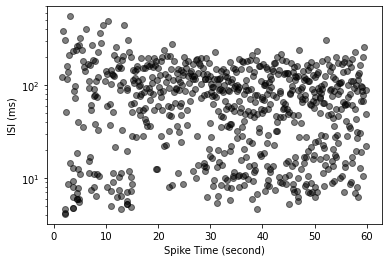

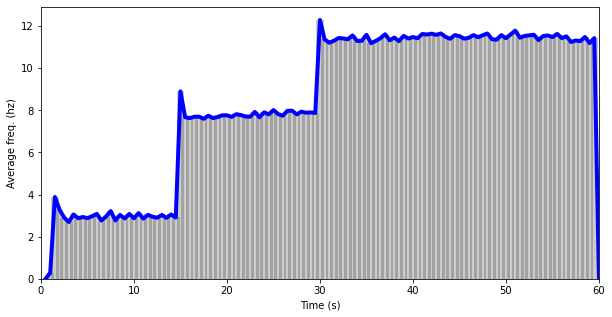

In [47]:
spike_times, voltage = run_network_simulation(network_events={15:'disconnect_GABA_increase_adapt',30: 'double_EPSP'})
isi_time_plot(spike_times.spike_trains())
hz, bin_time = binned_hz_pop(spike_times.spike_trains(), 600000)
save_spike_times(spike_times, tag='drop_gaba_switch_')
save_net_currents(voltage, spike_times, tag='drop_gaba_switch_')

## Experiment: Increase the EPSP rate

Now we can try increasing the EPSP rate in our default network. here we will increase the EPSP rate from 30hz to 60hz at 30 seconds. Note how the overall firing rate does not increase too much.

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


=== Net Sim Start ===
['none' 'double_EPSP']
[30 30]
Starting simulation at t=0. s for a duration of 30. s
10.5384 s (35%) simulated in 10s, estimated 18s remaining.
20.4711 s (68%) simulated in 20s, estimated 9s remaining.
30. s (100%) simulated in 29s
Increasing EPSP


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "p_w := clip(_p_w_synapses_1__p_w_neurongroup_subgroup__p_w_neurongroup_pr, 0.01, 1) (constant) (subexpression)"
 [brian2.codegen.generators.base]


Starting simulation at t=30. s for a duration of 30. s
9.7219 s (32%) simulated in 10s, estimated 21s remaining.
19.5214 s (65%) simulated in 20s, estimated 11s remaining.
29.3256 s (97%) simulated in 30s, estimated 1s remaining.
30. s (100%) simulated in 30s
simulation took 1.3277870694796243


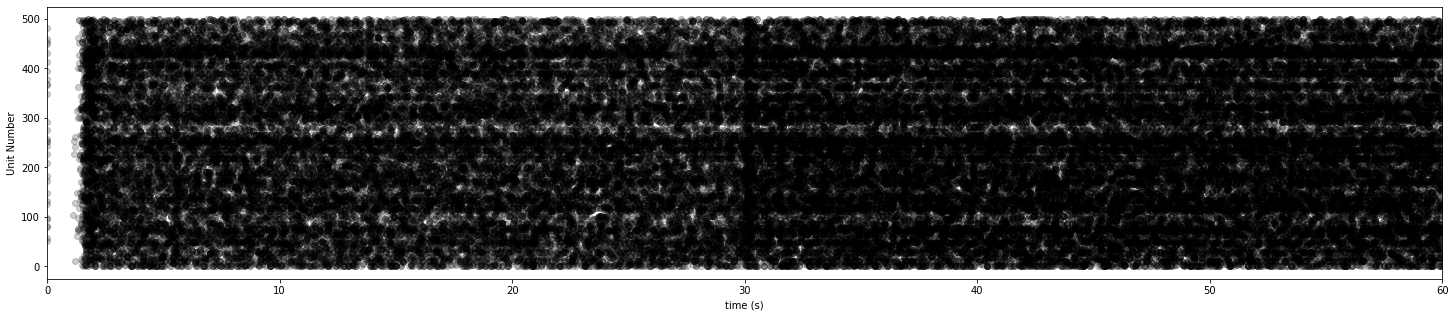

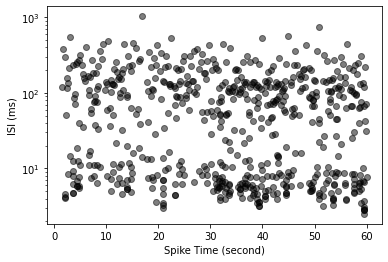

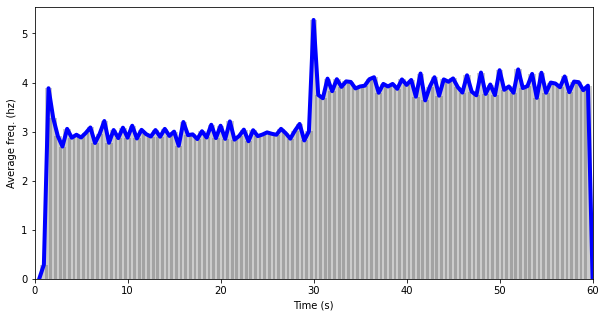

In [48]:
spike_times, voltage = run_network_simulation(network_events={30:'double_EPSP'})
spike_raster(spike_times.spike_trains(), xlim=(0, 60))
isi_time_plot(spike_times.spike_trains())
hz, bin_time = binned_hz_pop(spike_times.spike_trains(), 600000)
